# Example 2 with `pymc` models

This notebook shows an example of using synthetic control in a situation where we do not have untreated control units of a similar nature to the treated unit. So in this example we just have a single time series of observations and the predictor variables are simply time and month.

In [1]:
import arviz as az
import pandas as pd
import pathlib

In [2]:
# %config InlineBackend.figure_format = 'svg'
az.style.use("arviz-darkgrid")

In [3]:
%load_ext autoreload
%autoreload 2

## Example

Load data

In [4]:
its_data_path = pathlib.Path.cwd().parents[1] / "causalpy" / "data" / "its.csv"
df = pd.read_csv(its_data_path, parse_dates=["date"])
df.set_index("date", inplace=True)
treatment_time = pd.to_datetime("2017-01-01")
df.head()

,month,year,t,y
date,,,,
2010-01-31,1,2010,0,25.058186
2010-02-28,2,2010,1,27.189812
2010-03-31,3,2010,2,26.487551
2010-04-30,4,2010,3,31.241716
2010-05-31,5,2010,4,40.753973


Run the analysis

In [5]:
from causalpy.pymc_experiments import SyntheticControl
from causalpy.pymc_models import LinearRegression

result = SyntheticControl(
    df,
    treatment_time,
    formula="y ~ 1 + t + C(month)",
    prediction_model=LinearRegression(),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


/Users/benjamv/mambaforge/envs/CausalPy/lib/python3.10/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/benjamv/mambaforge/envs/CausalPy/lib/python3.10/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/benjamv/mambaforge/envs/CausalPy/lib/python3.10/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circula

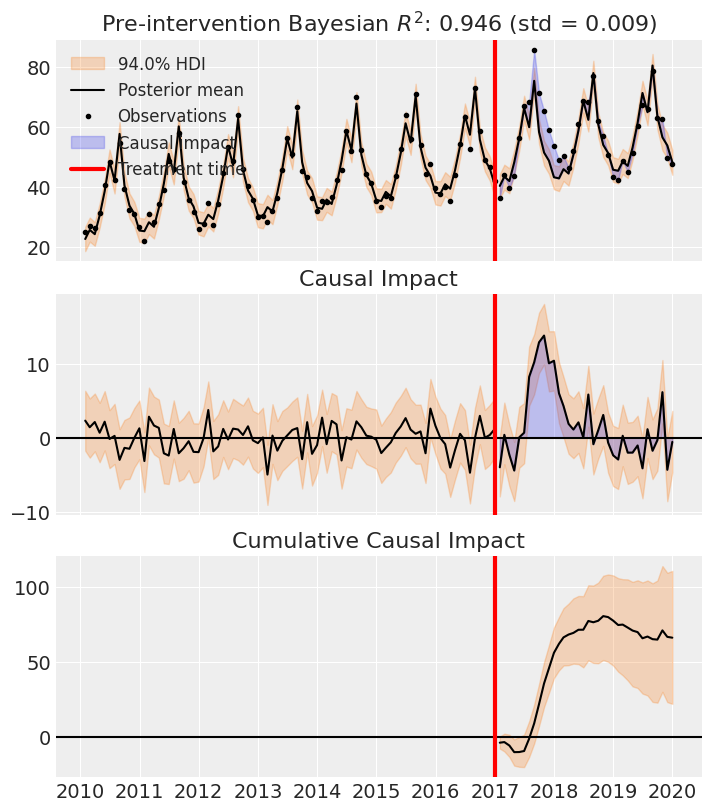

In [6]:
fig, ax = result.plot()

In [7]:
result.summary()

===============================Synthetic Control================================
Formula: y ~ 1 + t + C(month)
Model coefficients:
  Intercept                     22.72, 94% HDI [21.14, 24.26]
  C(month)[T.2]                 2.86, 94% HDI [0.83, 4.80]
  C(month)[T.3]                 1.17, 94% HDI [-0.84, 3.16]
  C(month)[T.4]                 7.13, 94% HDI [5.11, 9.12]
  C(month)[T.5]                 15.05, 94% HDI [13.02, 17.07]
  C(month)[T.6]                 24.79, 94% HDI [22.76, 26.86]
  C(month)[T.7]                 18.23, 94% HDI [16.25, 20.23]
  C(month)[T.8]                 33.47, 94% HDI [31.41, 35.47]
  C(month)[T.9]                 16.24, 94% HDI [14.23, 18.22]
  C(month)[T.10]                9.19, 94% HDI [7.18, 11.16]
  C(month)[T.11]                6.28, 94% HDI [4.33, 8.26]
  C(month)[T.12]                0.57, 94% HDI [-1.42, 2.63]
  t                             0.21, 94% HDI [0.19, 0.23]
  sigma                         1.97, 94% HDI [1.70, 2.30]


As well as the model coefficients, we might be interested in the avarage causal impact and average cumulative causal impact.

<div class="alert alert-info">

Note

Better output for the summary statistics are in progress!

</div>

First we ask for summary statistics of the causal impact over the entire post-intervention period.

In [8]:
az.summary(result.post_impact.mean("obs_ind"))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,1.839,0.67,0.611,3.079,0.012,0.009,2959.0,3158.0,1.0


<div class="alert alert-warning">

Warning

Care must be taken with the mean impact statistic. It only makes sense to use this statistic if it looks like the intervention had a lasting (and roughly constant) effect on the outcome variable. If the effect is transient, then clearly there will be a lot of post-intervention period where the impact of the intervention has 'worn off'. If so, then it will be hard to interpret the mean impacts real meaning.

</div>

We can also ask for the summary statistics of the _cumulative_ causal impact.

In [9]:
# get index of the final time point
index = result.post_impact_cumulative.obs_ind.max()
# grab the posterior distribution of the cumulative impact at this final time point
last_cumulative_estimate = result.post_impact_cumulative.sel({"obs_ind": index})
# get summary stats
az.summary(last_cumulative_estimate)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,66.204,24.114,22.011,110.834,0.444,0.314,2959.0,3158.0,1.0
